In [295]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np
import pickle

In [296]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [3]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [ ]:
def get_feature_2(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
    hand_name = ['left', 'right']
    
    fingertip_pos = np.zeros([2, 5, 3])
    
    hand_palm_pos = np.zeros([2, 3])
    hand_palm_rpy = np.zeros([2, 3])
    hand_palm_unit_vector = np.zeros([2, 3])
    dist_fingertip_palm = np.zeros([10])
    
    feature = np.zeros([2*3 + 2*3 + 10 + 10])
    
    for hand_idx, hand in enumerate(hand_name):
        if not hand in frame['hands']:
            continue
        hand_palm_pos[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        hand_palm_rpy[hand_idx] = np.array([ frame['hands'][hand]['roll'],
                                                    frame['hands'][hand]['pitch'],
                                                    frame['hands'][hand]['yaw']])
        hand_palm_unit_vector[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        for finger_idx, finger in enumerate(finger_name):
            fingertip_pos[hand_idx, finger_idx] = (
                np.array(frame['hands'][hand]['fingers'][finger]['bones']['distal']['next_joint'])
            )
            
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    dist_btw_fingertip = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2)
        
    feature[0:6] = hand_palm_pos.reshape(6)
    feature[6:12] = hand_palm_rpy.reshape(6)
    feature[12:22] = dist_btw_fingertip.reshape(10)
    
#     print(feature[12+5:12+6])
#     print(frame['hands']['right']['fingers']['thumb']['bones']['distal']['next_joint'])
#     print(hand_palm_pos[1])
    return feature
    

In [4]:
def get_timestep_from_data(json_data, pick_frame_every_no):
    timestep = np.zeros([0, dimensions])
    curr_idx = 0
    
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
            continue
        feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
        timestep = np.vstack((timestep, feature))
        curr_idx += 1
        
    return timestep

    

In [5]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
        feature = get_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [6]:
def get_fake_speedup_timesteps_1(percent, json_data, pick_frame_every_no):
    return get_timesteps(json_data, pick_frame_every_no*(100+percent)//100)

In [7]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [8]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [9]:
speedup = 10
pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)

In [299]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
            
        print(json_data[0]['hands']['right'])
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
        _timesteps = get_fake_speedup_timesteps_2(+10, _timesteps, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)

{'hand_palm_position': [18.923126220703125, 356.4434814453125, 49.24920654296875], 'yaw': -4.026437970744183, 'fingers': {'pinky': {'widt': 12.850244522094727, 'bones': {'metacarpal': {'next_joint': [48.97883987426758, 351.27197265625, 38.37908172607422], 'direction': [-0.1688673049211502, 0.12381534278392792, 0.9778310060501099], 'prev_joint': [40.9714241027832, 357.1430969238281, 84.74625396728516]}, 'distal': {'next_joint': [53.545677185058594, 333.864501953125, -12.109965324401855], 'direction': [0.12642981112003326, 0.607515275478363, 0.784181535243988], 'prev_joint': [55.222259521484375, 341.9207458496094, -1.7109555006027222]}, 'intermediate': {'next_joint': [55.222259521484375, 341.9207458496094, -1.7109555006027222], 'direction': [-0.02592187374830246, 0.410762757062912, 0.9113736748695374], 'prev_joint': [54.83220291137695, 348.1016540527344, 12.00284194946289]}, 'proximal': {'next_joint': [54.83220291137695, 348.1016540527344, 12.00284194946289], 'direction': [-0.21517115831

{'hand_palm_position': [-10.653929710388184, 413.62005615234375, 17.28590965270996], 'yaw': -8.254509958329947, 'fingers': {'pinky': {'widt': 14.24072551727295, 'bones': {'metacarpal': {'next_joint': [20.262847900390625, 406.7981872558594, -0.07392547279596329], 'direction': [-0.07309456914663315, -0.16301771998405457, 0.9839117527008057], 'prev_joint': [16.396724700927734, 398.17584228515625, 51.96720504760742]}, 'distal': {'next_joint': [1.7739802598953247, 395.6339416503906, -58.1800422668457], 'direction': [0.5279682278633118, 0.49006137251853943, 0.6936061382293701], 'prev_joint': [9.868548393249512, 403.1473388671875, -47.545989990234375]}, 'intermediate': {'next_joint': [9.868548393249512, 403.1473388671875, -47.545989990234375], 'direction': [0.2695700526237488, 0.144166961312294, 0.9521280527114868], 'prev_joint': [14.558228492736816, 405.6553955078125, -30.981924057006836]}, 'proximal': {'next_joint': [14.558228492736816, 405.6553955078125, -30.981924057006836], 'direction': 

{'hand_palm_position': [13.163004875183105, 290.9200439453125, 102.39678192138672], 'yaw': -5.874244926969965, 'fingers': {'pinky': {'widt': 14.012598037719727, 'bones': {'metacarpal': {'next_joint': [45.29091262817383, 285.55169677734375, 91.06769561767578], 'direction': [-0.15680234134197235, 0.38872405886650085, 0.907913327217102], 'prev_joint': [37.39847183227539, 305.11761474609375, 136.76632690429688]}, 'distal': {'next_joint': [51.123172760009766, 248.97413635253906, 48.09536361694336], 'direction': [0.15998266637325287, 0.9250138998031616, 0.3446083962917328], 'prev_joint': [53.45719909667969, 262.4693908691406, 53.12294006347656]}, 'intermediate': {'next_joint': [53.45719909667969, 262.4693908691406, 53.12294006347656], 'direction': [-0.03466198965907097, 0.741829514503479, 0.6696919798851013], 'prev_joint': [52.883384704589844, 274.75006103515625, 64.20940399169922]}, 'proximal': {'next_joint': [52.883384704589844, 274.75006103515625, 64.20940399169922], 'direction': [-0.2536

{'hand_palm_position': [49.083011627197266, 364.37457275390625, 78.34445190429688], 'yaw': 2.3346207975946953, 'fingers': {'pinky': {'widt': 12.707629203796387, 'bones': {'metacarpal': {'next_joint': [80.33226776123047, 360.6907958984375, 70.62931060791016], 'direction': [-0.28062704205513, 0.05208899825811386, 0.9584023952484131], 'prev_joint': [67.01275634765625, 363.1631164550781, 116.11833953857422]}, 'distal': {'next_joint': [98.1476821899414, 351.52801513671875, 17.75415802001953], 'direction': [-0.12857656180858612, 0.43936336040496826, 0.8890601992607117], 'prev_joint': [96.36526489257812, 357.6187744140625, 30.07892608642578]}, 'intermediate': {'next_joint': [96.36526489257812, 357.6187744140625, 30.07892608642578], 'direction': [-0.2693963646888733, 0.23700645565986633, 0.9334096312522888], 'prev_joint': [92.12761688232422, 361.346923828125, 44.7616081237793]}, 'proximal': {'next_joint': [92.12761688232422, 361.346923828125, 44.7616081237793], 'direction': [-0.414779603481292

{'hand_palm_position': [88.23004150390625, 294.78271484375, 56.15141677856445], 'yaw': 1.0498337050227846, 'fingers': {'pinky': {'widt': 14.0040283203125, 'bones': {'metacarpal': {'next_joint': [119.47853088378906, 291.51953125, 47.06147003173828], 'direction': [-0.25532421469688416, -0.07103704661130905, 0.9642423391342163], 'prev_joint': [107.2460708618164, 288.1161804199219, 93.25785827636719]}, 'distal': {'next_joint': [120.31341552734375, 284.4527282714844, -7.337131977081299], 'direction': [0.1388428658246994, 0.3661026060581207, 0.9201584458351135], 'prev_joint': [122.1728515625, 289.355712890625, 4.985977649688721]}, 'intermediate': {'next_joint': [122.1728515625, 289.355712890625, 4.985977649688721], 'direction': [0.04035024344921112, 0.21591152250766754, 0.9755788445472717], 'prev_joint': [122.7860336303711, 292.6368103027344, 19.811351776123047]}, 'proximal': {'next_joint': [122.7860336303711, 292.6368103027344, 19.811351776123047], 'direction': [-0.12039173394441605, -0.040

KeyboardInterrupt: 

In [61]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [12]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [13]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [14]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [15]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 5s 7ms/step - loss: 2.9764 - acc: 0.0365 - val_loss: 2.9704 - val_acc: 0.0526
Epoch 2/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.9563 - acc: 0.0512 - val_loss: 2.9011 - val_acc: 0.0731
Epoch 3/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.9167 - acc: 0.0526 - val_loss: 2.7855 - val_acc: 0.0819
Epoch 4/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.8525 - acc: 0.0804 - val_loss: 2.6644 - val_acc: 0.0965
Epoch 5/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.7583 - acc: 0.0950 - val_loss: 2.6578 - val_acc: 0.1053
Epoch 6/1000
684/684 [==============================] - 3s 5ms/step - loss: 2.6759 - acc: 0.0980 - val_loss: 2.4224 - val_acc: 0.1959
Epoch 7/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.5424 - acc: 0.1404 - val_loss: 2.3662 - val_acc: 0.2076
Epoch 8/1000
684

684/684 [==============================] - 3s 4ms/step - loss: 1.5695 - acc: 0.4020 - val_loss: 1.3088 - val_acc: 0.4766
Epoch 122/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5974 - acc: 0.4094 - val_loss: 1.2911 - val_acc: 0.4912
Epoch 123/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.5935 - acc: 0.4020 - val_loss: 1.2726 - val_acc: 0.4883
Epoch 124/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.5488 - acc: 0.3904 - val_loss: 1.2857 - val_acc: 0.4942
Epoch 125/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6095 - acc: 0.3743 - val_loss: 1.2558 - val_acc: 0.5205
Epoch 126/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5847 - acc: 0.3977 - val_loss: 1.2641 - val_acc: 0.5205
Epoch 127/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5209 - acc: 0.3904 - val_loss: 1.2687 - val_acc: 0.4883
Epoch 128/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 1.2752 - acc: 0.5146 - val_loss: 0.9439 - val_acc: 0.6696
Epoch 242/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1664 - acc: 0.5658 - val_loss: 0.9194 - val_acc: 0.6725
Epoch 243/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2576 - acc: 0.5365 - val_loss: 0.9205 - val_acc: 0.6842
Epoch 244/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2231 - acc: 0.5351 - val_loss: 0.8972 - val_acc: 0.7018
Epoch 245/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2092 - acc: 0.5439 - val_loss: 0.8797 - val_acc: 0.6988
Epoch 246/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1680 - acc: 0.5541 - val_loss: 0.8856 - val_acc: 0.6754
Epoch 247/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2202 - acc: 0.5556 - val_loss: 0.9019 - val_acc: 0.6813
Epoch 248/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 1.0543 - acc: 0.6082 - val_loss: 0.7180 - val_acc: 0.7515
Epoch 362/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0719 - acc: 0.6067 - val_loss: 0.6971 - val_acc: 0.7515
Epoch 363/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0964 - acc: 0.6053 - val_loss: 0.6994 - val_acc: 0.7544
Epoch 364/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1486 - acc: 0.6023 - val_loss: 0.7267 - val_acc: 0.7485
Epoch 365/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0402 - acc: 0.6184 - val_loss: 0.7038 - val_acc: 0.7719
Epoch 366/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0320 - acc: 0.6447 - val_loss: 0.6906 - val_acc: 0.7661
Epoch 367/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.0521 - acc: 0.6126 - val_loss: 0.6911 - val_acc: 0.7632
Epoch 368/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 0.9004 - acc: 0.6871 - val_loss: 0.5934 - val_acc: 0.8041
Epoch 482/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8770 - acc: 0.6754 - val_loss: 0.5851 - val_acc: 0.7924
Epoch 483/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9269 - acc: 0.6857 - val_loss: 0.5771 - val_acc: 0.7982
Epoch 484/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9055 - acc: 0.6813 - val_loss: 0.5778 - val_acc: 0.7953
Epoch 485/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9464 - acc: 0.6623 - val_loss: 0.5947 - val_acc: 0.7895
Epoch 486/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9667 - acc: 0.6608 - val_loss: 0.5785 - val_acc: 0.7895
Epoch 487/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.9564 - acc: 0.6681 - val_loss: 0.5922 - val_acc: 0.7865
Epoch 488/1000
684/684 [==============================] - 3s 5m

684/684 [==============================] - 3s 4ms/step - loss: 0.8078 - acc: 0.7149 - val_loss: 0.5435 - val_acc: 0.8012
Epoch 602/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.8431 - acc: 0.7047 - val_loss: 0.5508 - val_acc: 0.8070
Epoch 603/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.7602 - acc: 0.7529 - val_loss: 0.5450 - val_acc: 0.8129
Epoch 604/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.8461 - acc: 0.7135 - val_loss: 0.5426 - val_acc: 0.8158
Epoch 605/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8854 - acc: 0.7047 - val_loss: 0.5349 - val_acc: 0.8070
Epoch 606/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8486 - acc: 0.6974 - val_loss: 0.5346 - val_acc: 0.8099
Epoch 607/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8146 - acc: 0.7222 - val_loss: 0.5344 - val_acc: 0.8129
Epoch 608/1000
684/684 [==============================] - 3s 5m

684/684 [==============================] - 3s 4ms/step - loss: 0.8174 - acc: 0.7222 - val_loss: 0.5076 - val_acc: 0.8129
Epoch 722/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.7941 - acc: 0.7222 - val_loss: 0.5012 - val_acc: 0.8187
Epoch 723/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7533 - acc: 0.7368 - val_loss: 0.5054 - val_acc: 0.8099
Epoch 724/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8302 - acc: 0.7325 - val_loss: 0.5035 - val_acc: 0.8129
Epoch 725/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7769 - acc: 0.7383 - val_loss: 0.4994 - val_acc: 0.8187
Epoch 726/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7516 - acc: 0.7339 - val_loss: 0.4809 - val_acc: 0.8216
Epoch 727/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7379 - acc: 0.7354 - val_loss: 0.4835 - val_acc: 0.8158
Epoch 728/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 5ms/step - loss: 0.7282 - acc: 0.7500 - val_loss: 0.4653 - val_acc: 0.8275loss: 0.702
Epoch 842/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.7612 - acc: 0.7325 - val_loss: 0.4663 - val_acc: 0.8304
Epoch 843/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.6894 - acc: 0.7880 - val_loss: 0.4653 - val_acc: 0.8246
Epoch 844/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7842 - acc: 0.7456 - val_loss: 0.4617 - val_acc: 0.8216
Epoch 845/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7948 - acc: 0.7471 - val_loss: 0.4591 - val_acc: 0.8216
Epoch 846/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7422 - acc: 0.7471 - val_loss: 0.4605 - val_acc: 0.8158
Epoch 847/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7774 - acc: 0.7383 - val_loss: 0.4610 - val_acc: 0.8187
Epoch 848/1000
684/684 [============================

684/684 [==============================] - 3s 4ms/step - loss: 0.7413 - acc: 0.7675 - val_loss: 0.4415 - val_acc: 0.8246
Epoch 962/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7174 - acc: 0.7719 - val_loss: 0.4411 - val_acc: 0.8187
Epoch 963/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.6908 - acc: 0.7792 - val_loss: 0.4381 - val_acc: 0.8187
Epoch 964/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7406 - acc: 0.7442 - val_loss: 0.4396 - val_acc: 0.8158
Epoch 965/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7928 - acc: 0.7281 - val_loss: 0.4444 - val_acc: 0.8216
Epoch 966/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7517 - acc: 0.7690 - val_loss: 0.4375 - val_acc: 0.8363
Epoch 967/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8057 - acc: 0.7456 - val_loss: 0.4452 - val_acc: 0.8216
Epoch 968/1000
684/684 [==============================] - 3s 4m

NameError: name 'pickle' is not defined

In [18]:
model.save("./history/model26032024.h5")
with open('./history/history26032024.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [256]:
model = load_model("./history/model26032024.h5")
with open('./history/history26032024.pkl', 'rb') as handle:
    load_history = pickle.load(handle)

In [257]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 641us/step
Test score: 0.409651071007
Test accuracy: 0.853801170288


In [20]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


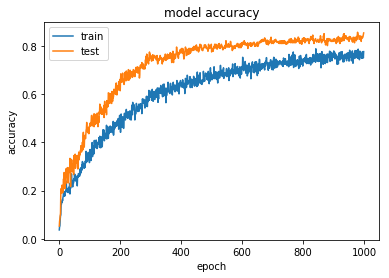

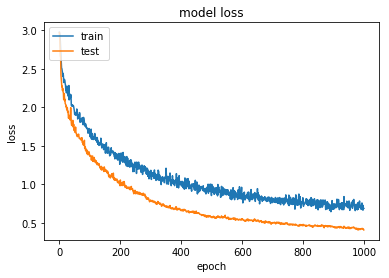

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction section

In [266]:
x_predict = np.zeros([0, timesteps, dimensions])
y_actual = np.zeros([0])

test_data_per_word = 10

for word_no, word in enumerate(words):
    for data_no in range(test_data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)

        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        _timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x_predict = np.vstack((x_predict, [_timesteps]))
        y_actual = np.append(y_actual, word_no)
        
x_predict_norm = (x_predict-x_mean)/x_std
    
prediction = model.predict(x_predict_norm, verbose = 1)

190/190 [==============================] - 0s 1ms/step


In [291]:
y_actual = y_test
test_data_per_word = 18
prediction = model.predict(x_test, verbose = 1)

342/342 [==============================] - 0s 370us/step


In [292]:
confusion_matrix = np.zeros([len(words), len(words)])
prediction_word_index = np.argmax(prediction, axis = 1)

for idx in range(len(prediction_word_index)):
    actual = y_actual[idx]
    result = prediction_word_index[idx]
    confusion_matrix[int(actual)][result] += 1

In [293]:
test_acc = 0

for idx in range(len(words)):
    test_acc += confusion_matrix[idx][idx]
test_acc /= (test_data_per_word * len(words))

print(test_acc)


0.853801169591


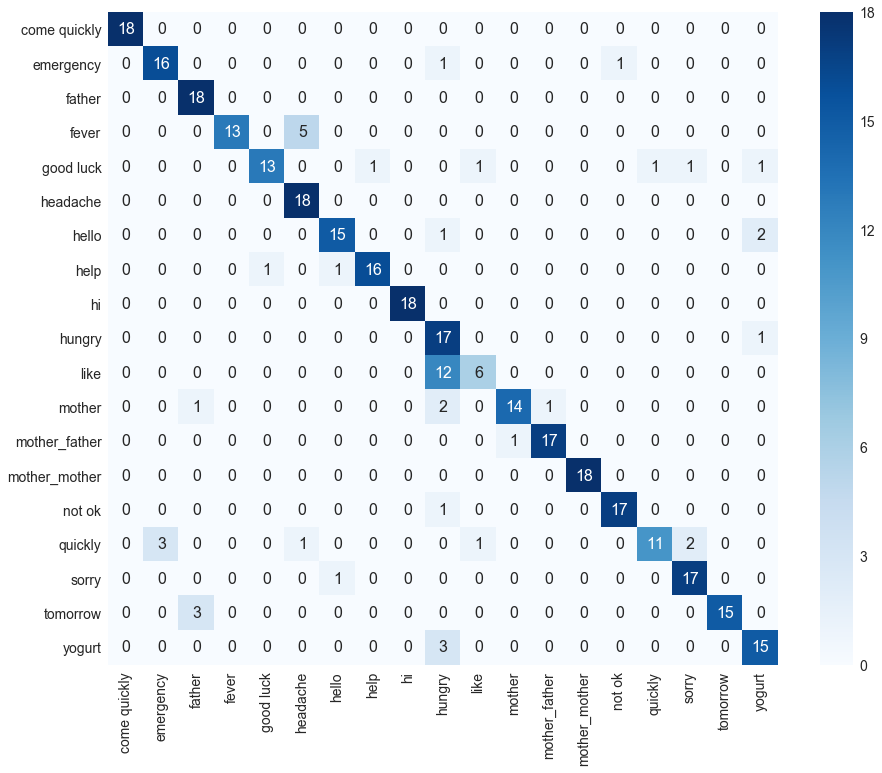

In [294]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
   
df_cm = pd.DataFrame(confusion_matrix, words, words)
plt.figure(figsize = (15,12))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size